<a href="https://colab.research.google.com/github/kotharisanjana/CMPE258_DeepLearning_Spring2023/blob/main/Assignment_3/d_NN_TorchLightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installation

!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 KB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.6/518.6 KB 33.5 MB/s eta 0:00:00


In [2]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# Generate non-linear data

n = 500
dim = 3
x = torch.rand(n, dim).float()
print('Input tensor shape =', x.shape)

Input tensor shape = torch.Size([500, 3])


In [4]:
# Initialize weights and bias

weights = torch.tensor([[2.0, -3.0, 6.0]]).T
bias = torch.tensor([[8]])
print('Weights shape =', weights.shape)
print('Bias shape =', bias.shape)

# non-linear 3 variable function we want to learn
y_true = (torch.einsum('ij, jk -> ik', (x**3),  weights) + torch.einsum('ij, jk -> ik', (x**2),  weights) + torch.einsum('ij, jk -> ik', x, weights) + bias).float()
print('Function output shape =', y_true.shape)

Weights shape = torch.Size([3, 1])
Bias shape = torch.Size([1, 1])
Function output shape = torch.Size([500, 1])


In [5]:
# Initialize hyperparamters
input_dim = dim
output_dim = 1
hidden_dim = 16
batch_size= 16

learning_rate = 0.01
num_epochs = 20

In [6]:
# Create dataset loader object

data = TensorDataset(x, y_true)
data_loader = DataLoader(data, batch_size=batch_size, shuffle=True)

In [7]:
# Non-linear model

class Model(pl.LightningModule):
  def __init__(self, input_dim, output_dim, hidden_dim):
    super().__init__()
    self.linear1 = nn.Linear(input_dim, hidden_dim)
    self.relu1 = nn.ReLU()
    self.linear2 = nn.Linear(hidden_dim, hidden_dim)
    self.relu2 = nn.ReLU()
    self.linear3 = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    l1 = self.linear1(x)
    r1 = self.relu1(l1)
    l2 = self.linear2(r1)
    r2 = self.relu2(l2)
    l3 = self.linear3(r2)
    return l3

  def training_step(self, batch):
    x, y_true = batch
    y_pred = self(x)
    loss_value = nn.MSELoss()(y_pred, y_true)
    return loss_value

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
    return optimizer

In [8]:
# Initialize trainer and model

trainer = pl.Trainer(max_epochs=num_epochs)
model = Model(input_dim, output_dim, hidden_dim)

/usr/local/lib/python3.8/dist-packages/lightning_fabric/accelerators/cuda.py:236: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [9]:
# Train model

trainer.fit(model, data_loader)

INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 64    
1 | relu1   | ReLU   | 0     
2 | linear2 | Linear | 272   
3 | relu2   | ReLU   | 0     
4 | linear3 | Linear | 17    
-----------------------------------
353       Trainable params
0         Non-trainable params
353       Total params
0.001     Total estimated model params size (MB)
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


After 20 epochs (batch size = 16), the MSE loss attained is 1.46

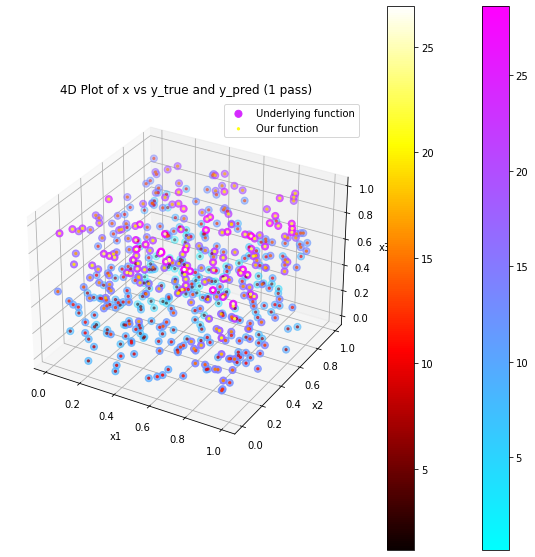

In [12]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=y_true, cmap='cool', label='Underlying function', s=50)
fig.colorbar(sc)
sc = ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=model(x).detach().numpy(), cmap='hot', label='Our function', marker='.')
fig.colorbar(sc)

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
ax.set_title('4D Plot of x vs y_true and y_pred (1 pass)')

plt.legend()
plt.show()